In [1]:
!pip install shap stable-baselines3[extra] > /dev/null 2>&1

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import shap
import pickle

from stable_baselines3 import PPO
from stable_baselines3.common.policies import obs_as_tensor
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

/usr/local/lib/python3.9/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.9/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_pa

In [3]:
train_og = pd.read_csv("/notebooks/ProcessedDataset/top001_train.csv")
test_og = pd.read_csv("/notebooks/ProcessedDataset/top001_test.csv")

train_enc = pd.read_csv("/notebooks/FinalDataset/top001_train_encoded.csv")
test_enc = pd.read_csv("/notebooks/FinalDataset/top001_test_encoded.csv")

x_train = train_enc.drop('attack_cat', axis=1)
y_train = train_enc['attack_cat']

x_test = test_enc.drop('attack_cat', axis=1)
y_test = test_enc['attack_cat']

x_train, y_train = shuffle(x_train, y_train, random_state=42)

model = PPO.load("/notebooks/Models/RL/RL_001_Balanced.zip", device="cpu")

target_names = ["Analysis", "Backdoors", "DoS", "Exploits", "Fuzzers", 
                "Generic", "Reconnaissance", "Shellcode", "Worms"]

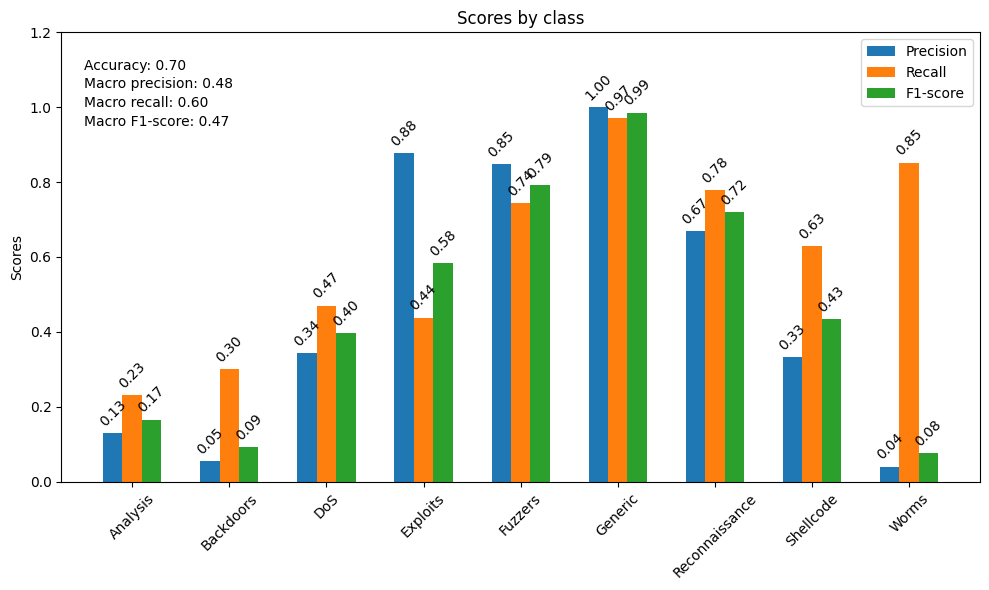

In [4]:
y_pred, _ = model.predict(x_test, deterministic=True)

report = classification_report(y_test, y_pred, output_dict=True, target_names=target_names, zero_division=0)

precision = [report[label]['precision'] for label in target_names]
recall = [report[label]['recall'] for label in target_names]
f1_score = [report[label]['f1-score'] for label in target_names]

plot_pos = np.arange(len(target_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(plot_pos - width, precision, width, label='Precision')
rects2 = ax.bar(plot_pos, recall, width, label='Recall')
rects3 = ax.bar(plot_pos + width, f1_score, width, label='F1-score')

ax.set_ylabel('Scores')
ax.set_title('Scores by class')
ax.set_xticks(plot_pos)
ax.set_xticklabels(target_names)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation=45)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.ylim(0, 1.2)
plt.xticks(rotation=45)
fig.tight_layout()

global_accuracy = report['accuracy']
global_precision = report['macro avg']['precision']
global_recall = report['macro avg']['recall']
global_f1 = report['macro avg']['f1-score']

plt.text(-0.5, 1.10, 'Accuracy: {0:.2f}'.format(global_accuracy), fontsize=10)
plt.text(-0.5, 1.05, 'Macro precision: {0:.2f}'.format(global_precision), fontsize=10)
plt.text(-0.5, 1.00, 'Macro recall: {0:.2f}'.format(global_recall), fontsize=10)
plt.text(-0.5, 0.95, 'Macro F1-score: {0:.2f}'.format(global_f1), fontsize=10)

plt.show()

In [4]:
def rl_prediction(state):
    obs = obs_as_tensor(state, model.policy.device)
    dis = model.policy.get_distribution(obs)
    probs = dis.distribution.probs
    probs_np = probs.detach().numpy()
    return probs_np 
    res, _ = model.predict(state, deterministic=True)
    return res

In [ ]:
# SHAP_explainer = shap.KernelExplainer(rl_prediction, 
#                                       shap.kmeans(x_train.values, 100))

# Referencia tanto para kmeans y sample
# shap.sample(x_train, 500))
# shap.kmeans(x_train.values, 500)
# 100 > 3s/it
# 500 > 10s/it

In [ ]:
# with open("/notebooks/Utils/SHAP_explainer.pkl", "wb") as file:
#    pickle.dump(SHAP_explainer, file)

In [5]:
with open("/notebooks/Utils/SHAP_explainer.pkl", "rb") as file:
    SHAP_explainer = pickle.load(file)

In [4]:
nsamples = 5_000

In [5]:
x_samples = x_train[:nsamples]
y_samples = y_train[:nsamples]

x_samples.to_csv(f'/notebooks/Utils/x_samples_{nsamples}.csv', index=False)
y_samples.to_csv(f'/notebooks/Utils/y_samples_{nsamples}.csv', index=False)

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


In [ ]:
# x_samples = pd.read_csv(f"/notebooks/Utils/x_samples_{nsamples}.csv")

# shap_values = SHAP_explainer.shap_values(x_samples)

# with open(f"/notebooks/Utils/shap_values_{nsamples}.pkl", "wb") as file:
    pickle.dump(shap_values, file)

  0%|          | 0/5000 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [8]:
with open(f"/notebooks/Utils/shap_values_{nsamples}.pkl", "rb") as file:
    shap_values = pickle.load(file)

## Disaggregated features

### Global

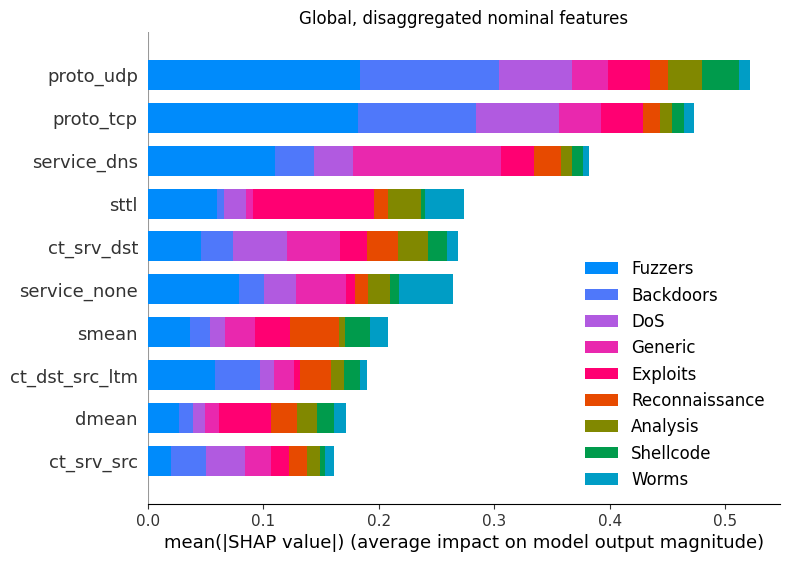

In [9]:
plt.figure()
shap.summary_plot(shap_values, x_train.columns.tolist(),
                  class_names=target_names,
                  max_display=10,
                  show=False)
plt.title(f"Global, disaggregated nominal features")
plt.show()

### Class

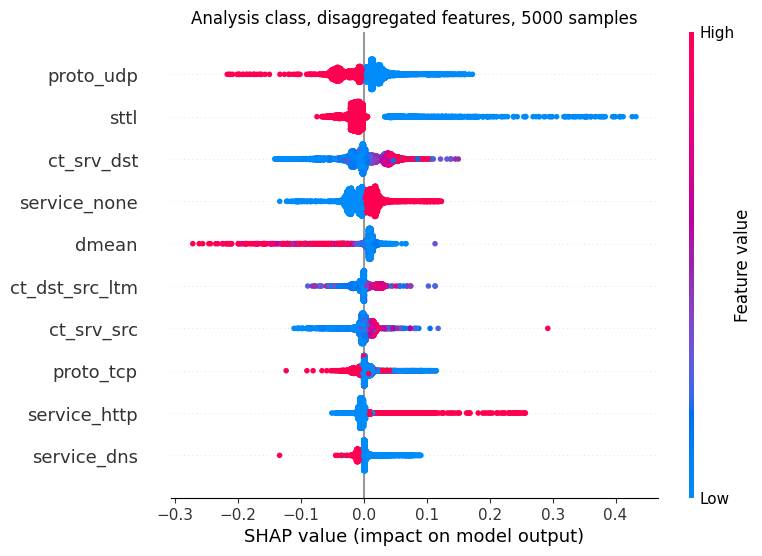

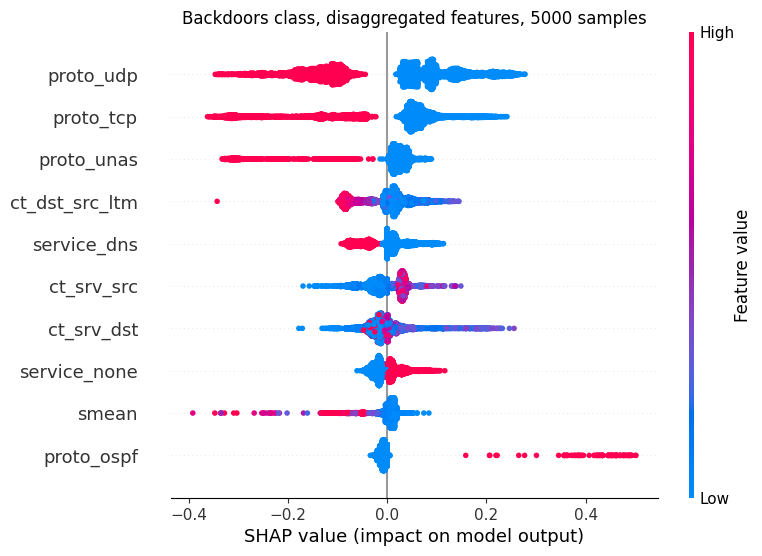

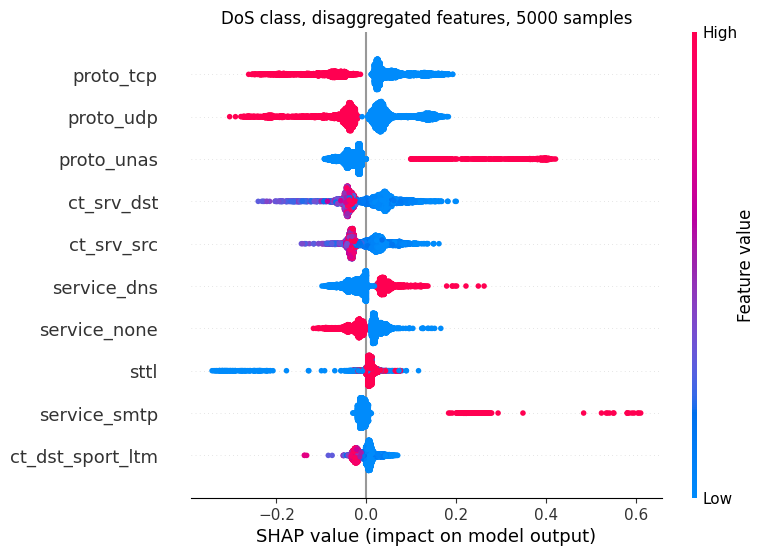

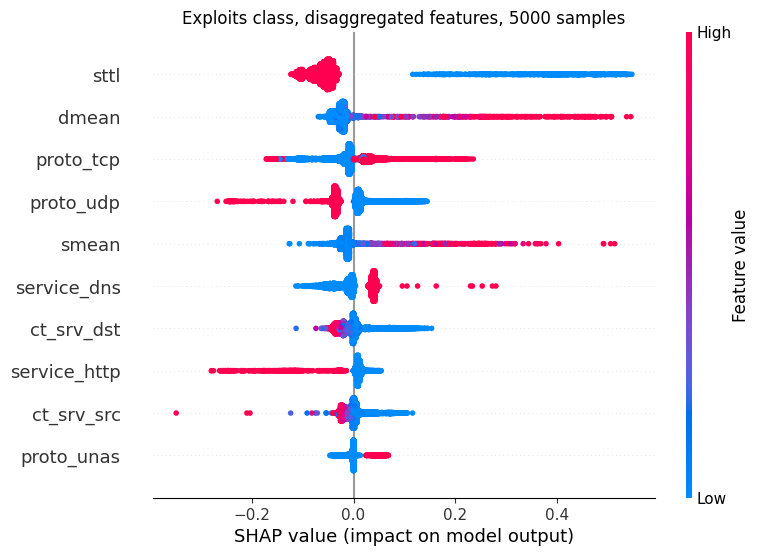

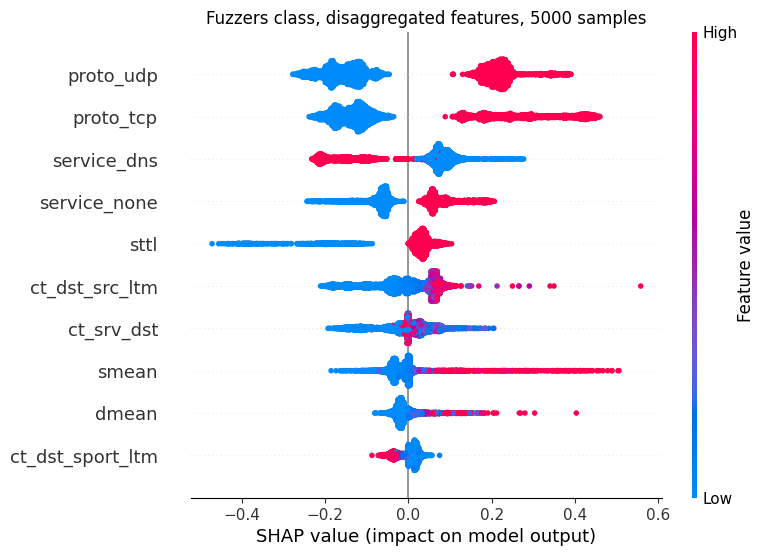

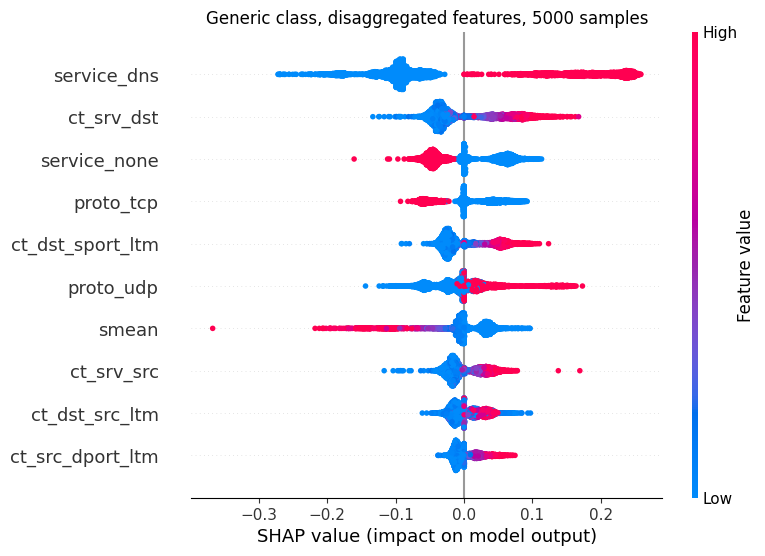

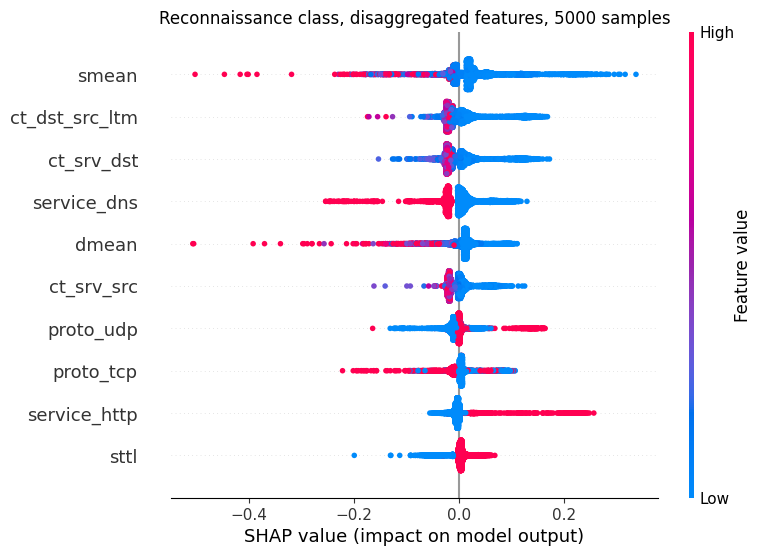

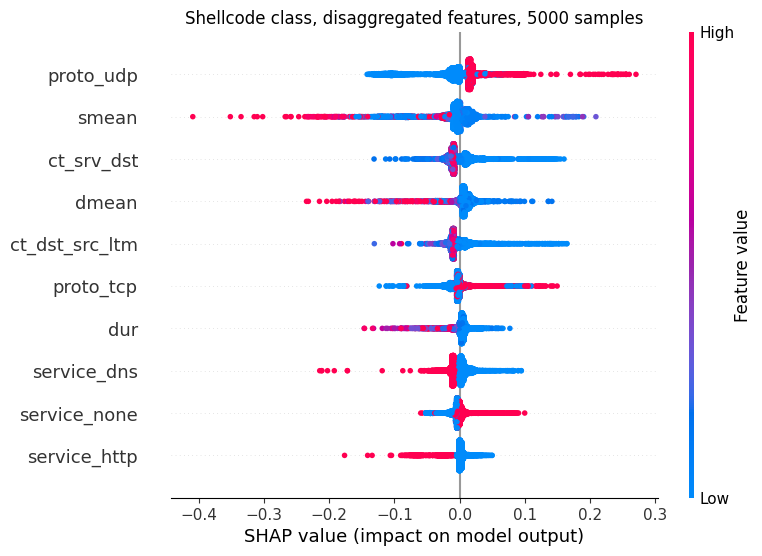

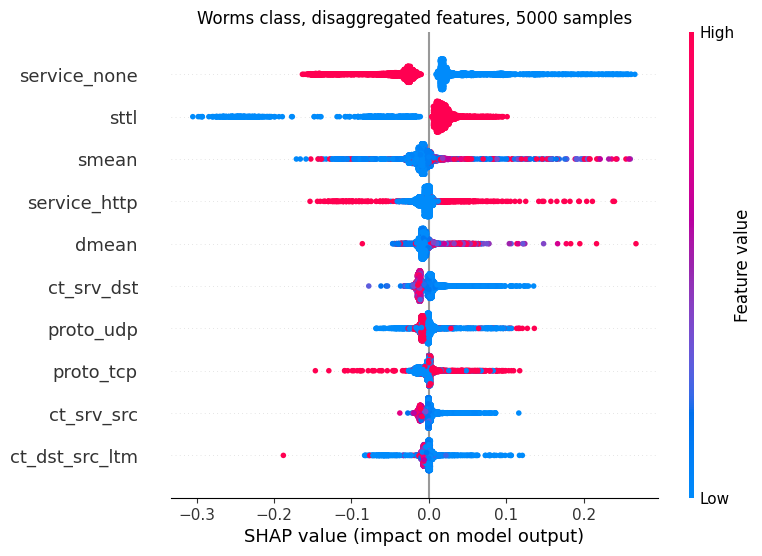

In [15]:
for i in range(len(shap_values)):
    plt.figure()
    shap.summary_plot(shap_values[i],
                      x_samples,
                      max_display=10,
                      plot_type="dot",
                      show=False)
    plt.title(f"{target_names[i]} class, disaggregated features, {nsamples} samples")
    plt.show()

## Aggregated features

In [ ]:
features = x_train.columns

proto_indices = [i for i, feature in enumerate(features) if feature.startswith('proto_')]
service_indices = [i for i, feature in enumerate(features) if feature.startswith('service_')]

proto_agg_values = []
service_agg_values = []

for class_index in range(len(shap_values)):
    proto_agg_values_class = np.sum(shap_values[class_index][:, proto_indices], axis=1)
    service_agg_values_class = np.sum(shap_values[class_index][:, service_indices], axis=1)
    proto_agg_values.append(proto_agg_values_class)
    service_agg_values.append(service_agg_values_class)
    
proto_agg_values = np.array(proto_agg_values)
service_agg_values = np.array(service_agg_values)

remaining_features = [i for i, feature in enumerate(features) if not feature.startswith(('proto_', 'service_'))]
remaining_shap_values = [shap_values[class_index][:, remaining_features] for class_index in range(len(shap_values))]

new_shap_values = [np.concatenate([remaining_shap_values[i], 
                                   proto_agg_values[i][:, np.newaxis], 
                                   service_agg_values[i][:, np.newaxis]], 
                                  axis=1) 
                   for i in range(len(shap_values))]

remaining_features_names = [feature for feature in features if not feature.startswith(('proto_', 'service_'))]
new_features_names = remaining_features_names + ['proto', 'service']

### Global

In [ ]:
plt.figure()
shap.summary_plot(new_shap_values, new_features_names,
                  class_names=target_names,
                  max_display=10,
                  show=False)
plt.title(f"Global, aggregated nominal features")
plt.show()

### Class

In [ ]:
for i in range(len(new_shap_values)):
    plt.figure()
    shap.summary_plot(new_shap_values[i], new_features_names, 
                      max_display=10,
                      plot_type="bar",
                      show=False)

    plt.title(f"{target_names[i]} class, aggregated nominal features")
    plt.show()